In [1]:
# !pip install shap
# !pip install kaggle
# !pip install kagglehub
!pip install matplotlib

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sazid28/advertising.csv")
# 각 채널(TV, 라디오, 신문)의 광고비 지출과 매출 데이터

c:\projects\ai-implementation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import os

# 경로에서 CSV 파일 읽기
csv_path = os.path.join(path, "Advertising.csv")
df = pd.read_csv(csv_path)


In [4]:
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   radio       200 non-null    float64
 3   newspaper   200 non-null    float64
 4   sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [6]:
df.describe()

,Unnamed: 0,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


In [7]:
# 각 광고 채널의 매출 기여도를 분석
import pandas as pd
import numpy as np
import shap   

import matplotlib as mpl
import matplotlib.pyplot as plt
 
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [8]:
# X,Y를 설정하고 데이터셋을 분리한 뒤 간단한 앙상블 모델인 랜덤포레스트 모델을 학습
# X, Y 설정
Y = df['sales']
X = df[['TV', 'radio', 'newspaper']]

# 트레인, 테스트 데이터 분리
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
 
# Random Forest Regressor 모델 학습
rf = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=20)
rf.fit(X_train, Y_train) 

,n_estimators,20
,criterion,'squared_error'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


- shap 라이브러리에는 모든 머신러닝 모델을 설명하는 데 사용할 수 있는(model-agnostic) shap.KernelExplainer 와 트리기반 머신러닝 모델에 최적화된 shap.TreeExplainer가 있음

In [9]:
# 설명 모델 생성
explainer = shap.TreeExplainer(rf)

# 트레인 셋에서의 shap value
shap_values_train = explainer(X_train)

# 테스트 셋에서의 shap value
shap_values_test = explainer(X_test)

# shap value 데이터 프레임 생성
df_shap_train = pd.DataFrame(shap_values_train.values, columns=X_train.columns)
df_shap_test = pd.DataFrame(shap_values_test.values, columns=X_test.columns)

In [10]:
X_train.head()

,TV,radio,newspaper
134,36.9,38.6,65.6
66,31.5,24.6,2.2
26,142.9,29.3,12.6
113,209.6,20.6,10.7
168,215.4,23.6,57.6


In [11]:
df_shap_train.head()

,TV,radio,newspaper
0,-5.596549,1.554187,0.260303
1,-4.420114,-0.069793,-0.022996
2,0.756101,0.994068,-0.040818
3,2.824184,-1.733645,-0.024862
4,3.169459,-0.752598,0.130336


- SHAP의 **기본값(base value)**은 모델이 어떤 피처 정보도 모를 때 예측하는 평균값임.
- 수식으로는 `base_values = expected_value = E[f(X)]`로 표현함.
- SHAP은 각 샘플 x에 대해 아래와 같이 예측값을 가법적으로 분해함.

    ```
    f(x) ≈ base_value + Σ_j ϕ_j(x)
    ```

    - 여기서 `base_value`는 기본값(베이스라인 예측)
    - `ϕ_j(x)`는 피처 j의 SHAP 값(해당 피처의 기여도)

- **트레인/테스트에서 base_value가 같은 이유**
    - TreeExplainer(회귀, 단일 출력 기준)는 base_value를 explainer가 가진 배경 데이터(보통 트레인 데이터) 분포에서 계산함.
    - 그래서 `shap_values_train.base_values[0]`와 `shap_values_test.base_values[0]`가 동일하게 나옴.
    - 배열처럼 보이지만, 각 샘플마다 같은 상수가 반복됨(샘플별로 달라지는 값이 아님).

In [12]:
# # 트레이닝 데이터의 기본값
# print('트레이닝 데이터: ','\n', df_shap_train.base_values)
# print('기본값: ', df_shap_train.base_values[0], '\n')

In [13]:
# # 테스트 데이터의 기본값
# print('테스트 데이터: ','\n', df_shap_test.base_values)
# print('기본값: ', df_shap_test.base_values[0])


In [14]:
shap_values_train.base_values[0]

np.float64(14.293187500000004)

In [15]:
shap_values_train.values[:5]

array([[-5.59654913,  1.554187  ,  0.26030251],
       [-4.42011389, -0.06979317, -0.02299597],
       [ 0.75610094,  0.99406846, -0.04081794],
       [ 2.82418373, -1.73364456, -0.02486217],
       [ 3.16945861, -0.75259781,  0.13033585]])

In [16]:
# 트레이닝 데이터의 기본값
print('트레이닝 데이터: ')
# 첫 번째 샘플의 각 feature별 SHAP 값을 리스트 형태로 출력
for i in range(len(shap_values_train.values[0])):
    print(f'  {[shap_values_train.values[0][i]]}')
print(f'기본값: {[shap_values_train.base_values[0]]}')
print('기본값: ', shap_values_train.base_values[0], '\n')

# 테스트 데이터의 기본값
print('테스트 데이터: ')
for i in range(len(shap_values_test.values[0])):
    print(f'  {[shap_values_test.values[0][i]]}')
print(f'기본값: {[shap_values_test.base_values[0]]}')
print('기본값: ', shap_values_test.base_values[0])

# 기본값은 트레이닝 데이터에서 계산되므로 테스트 데이터에서도 동일함
base_value = shap_values_train.base_values[0]

트레이닝 데이터: 
  [np.float64(-5.596549131386187)]
  [np.float64(1.5541869972187836)]
  [np.float64(0.2603025139630469)]
기본값: [np.float64(14.293187500000004)]
기본값:  14.293187500000004 

테스트 데이터: 
  [np.float64(-2.9169928665622944)]
  [np.float64(-0.7766660715290706)]
  [np.float64(-0.10557024660830575)]
기본값: [np.float64(14.293187500000004)]
기본값:  14.293187500000004


- 'values' 메서드로 데이터의 각 인스턴스에 대한 리스트를 확인할 수 있음.
- 각 배열의 처음 3개는 fearure에 대한 SHAP value이고 마지막 값이 기본값.
    - 이 경우 기본값이 14.293187500000004 

In [17]:
df_shap_train['BaseValue'] = base_value

In [18]:
# SHAP value + 기본값
df_shap_train['(ShapValues + BaseValue)'] = df_shap_train.iloc[:,0] + df_shap_train.iloc[:,1] + df_shap_train.iloc[:,2] + base_value

In [19]:
df_shap_train.head()

,TV,radio,newspaper,BaseValue,(ShapValues + BaseValue)
0,-5.596549,1.554187,0.260303,14.293188,10.511128
1,-4.420114,-0.069793,-0.022996,14.293188,9.780284
2,0.756101,0.994068,-0.040818,14.293188,16.002539
3,2.824184,-1.733645,-0.024862,14.293188,15.358865
4,3.169459,-0.752598,0.130336,14.293188,16.840384


In [20]:
# 예측값
df_shap_train['prediction'] = pd.DataFrame(list(rf.predict(X_train)))

In [21]:
df_shap_train.head()

,TV,radio,newspaper,BaseValue,(ShapValues + BaseValue),prediction
0,-5.596549,1.554187,0.260303,14.293188,10.511128,10.511128
1,-4.420114,-0.069793,-0.022996,14.293188,9.780284,9.780284
2,0.756101,0.994068,-0.040818,14.293188,16.002539,16.002539
3,2.824184,-1.733645,-0.024862,14.293188,15.358865,15.358865
4,3.169459,-0.752598,0.130336,14.293188,16.840384,16.840384


- 각 인스턴스의 피쳐에 대한 기본값 + SHAP 값이 예측값과 같다는 것을 확인

## Summary Plot

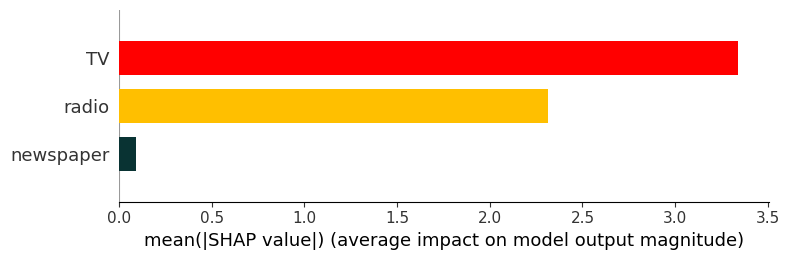

In [22]:
# 피쳐별 평균 임팩트 확인 - 각 피쳐에 해당하는 SHAP 값의 집계
# 해당 값이 클수록 모델의 결과에 미치는 영향이 크다고 해석
shap.summary_plot(shap_values_train,
                  X_train,
                  plot_type='bar',
                  color=['#093333', '#ffbf00', '#ff0000'])

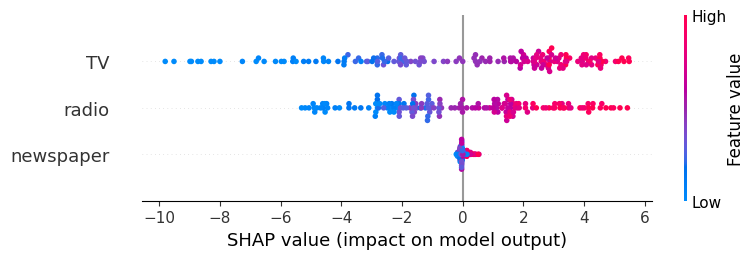

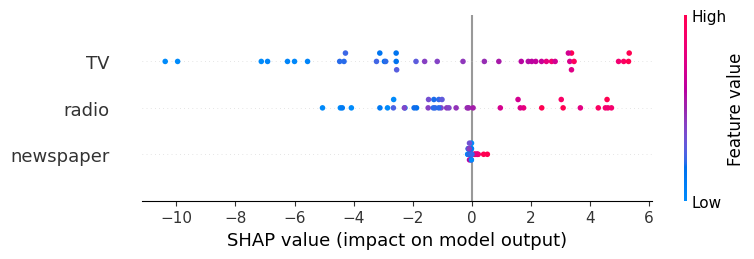

In [23]:
#트레이닝 데이터의 SHAP Summary plot
shap.summary_plot(shap_values_train,X_train) 
 
#테스트 데이터의 SHAP Summary plot
shap.summary_plot(shap_values_test,X_test) 


- 도표는 Y축에 피쳐, X축에 SHAP value의 범위를 표시함  
- 각 피쳐별 점은 데이터셋의 각 인스턴스(row, 개별 관측값, 샘플플) SHAP value를 의미함  
- 오른쪽 색상(세로 컬러바)은 해당 피쳐 값이 높음/낮음 구분함  
- 피쳐는 집계된 SHAP value 평균의 내림차순으로 정렬됨  

- 도표를 해석하면 아래와 같음  
  - 모델 결과(판매 수익)에 가장 큰 영향 미치는 피쳐는 TV임  
  - SHAP 절대값 평균에서도 TV가 가장 큼  
  - TV 광고비가 판매 수익에 가장 큰 영향 미침  
  - 라디오는 두 번째로 큰 영향, 신문은 거의 영향 없음  

- 마케팅 채널별 지출이 판매 수익에 미치는 영향은 다음과 같음  
  - TV: 값이 커질수록(빨간색) SHAP value, 즉 판매 수익 증가  
  - TV 값이 낮으면(파란색) SHAP value도 낮아짐 = 판매 수익 낮음  
  - 신문은 판매 수익에 영향 거의 없음, 도표에서 확인 가능  


## Dependence plot



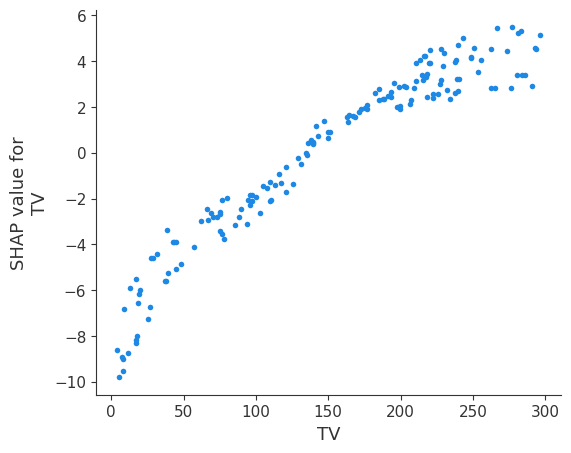

In [24]:
# 트레이닝 데이터의 TV 광고비 지출과 SHAP Values plot
shap.dependence_plot("TV", shap_values_train.values, X_train, interaction_index=None)

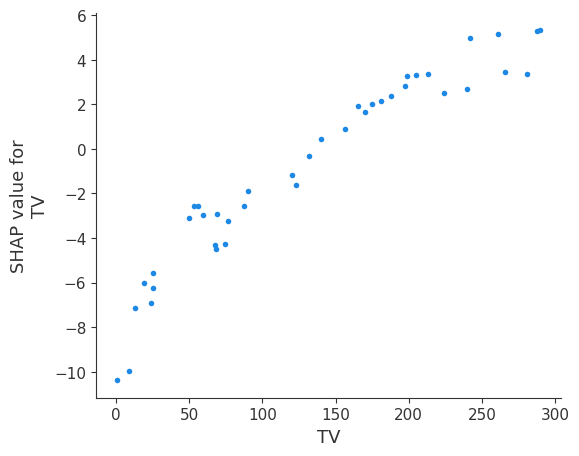

In [25]:
# 테스트 데이터의 TV 광고비 지출과 SHAP Values plot
shap.dependence_plot("TV", shap_values_test.values, X_test, interaction_index=None)

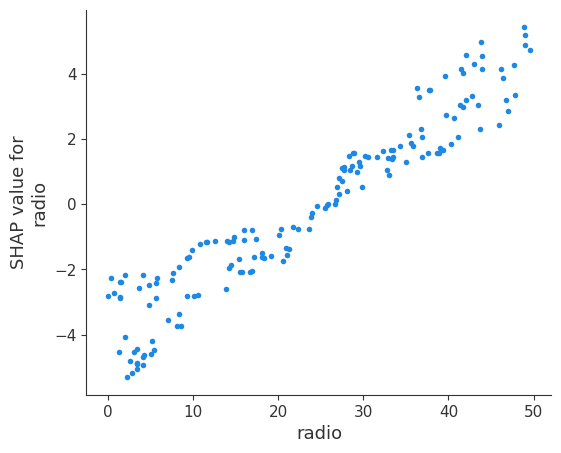

In [26]:
# 트레이닝 데이터의 Radio 광고비 지출과 SHAP Values plot
shap.dependence_plot("radio", shap_values_train.values, X_train, interaction_index=None)

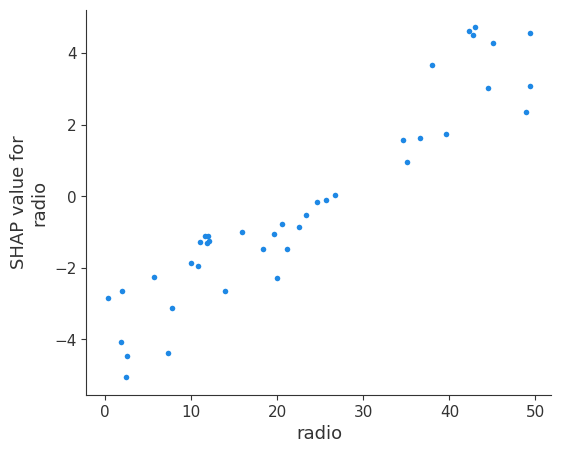

In [27]:
# 테스트 데이터의 Radio 광고비 지출과 SHAP Values plot
shap.dependence_plot("radio", shap_values_test.values, X_test, interaction_index=None)

- 광고 지출과 SHAP value 그래프는 광고 지출에 대한 시장 반응을 보여줌
    - TV 광고 지출이 증가하면 SHAP value도 함께 증가함
    - TV 광고비가 일정 금액 이상 올라가면 SHAP value 증가가 둔화되는 구간 나타남
- 라디오 광고도 지출이 늘수록 SHAP value 증가하는 경향 보임
    - 라디오 광고에서는 SHAP value가 정체되는 구간 따로 관찰되지 않음
    - 라디오 광고 정체 구간까지 지출을 늘려도 된다고 해석할 수 있음
- TV 광고 지출이 매출에 긍정적 영향을 주기 시작하는 임계 구간 파악 가능함
- 해당 임계 구간은 SHAP value가 0이 되는 X축(지출)의 값에서 확인 가능함

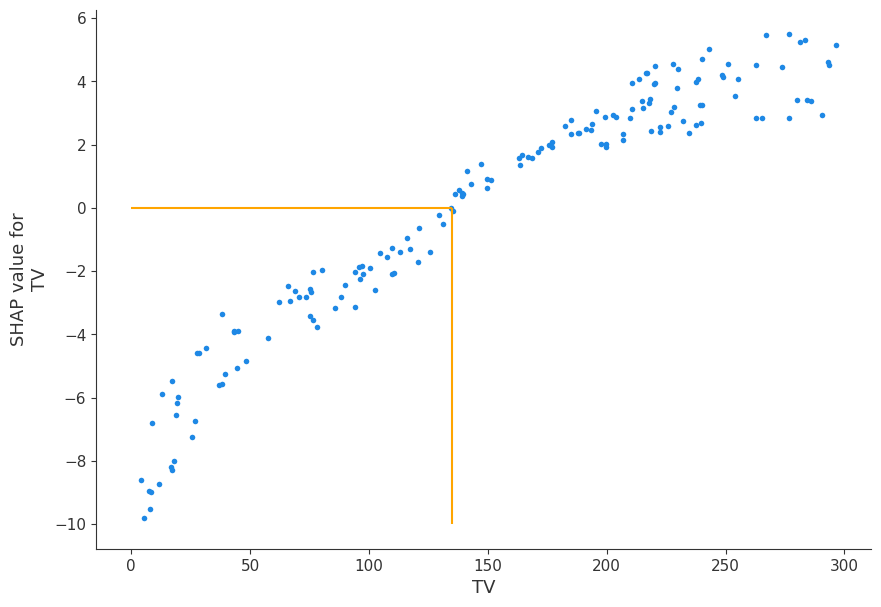

In [28]:
# TV 광고의 임계 지출액 탐색
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.hlines(0, 0, 135, colors='orange')
ax.vlines(135, -10, 0, colors='orange')
shap.dependence_plot("TV", shap_values_train.values, X_train, interaction_index=None, ax=ax)

## Interaction summary plot

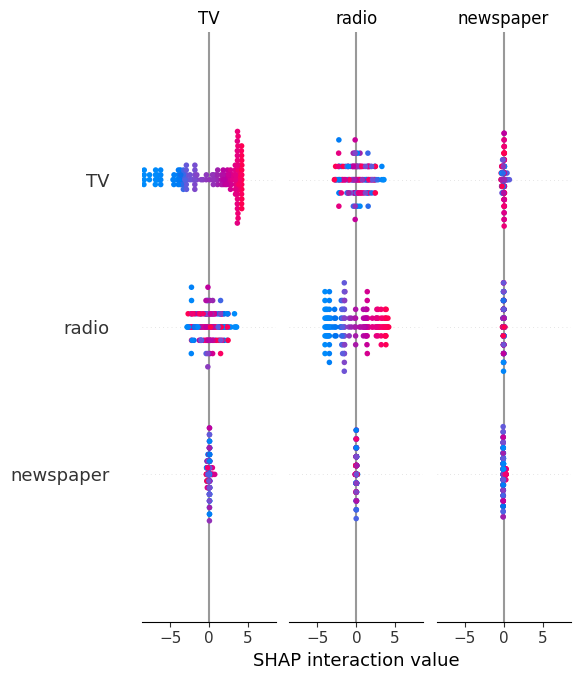

In [29]:
# SHAP interaction values
shap_interaction_values = shap.TreeExplainer(rf).shap_interaction_values(X_train)
 
# Interaction Summary Plot 
shap.summary_plot(shap_interaction_values, X_train)


- 도표에서 서로 다른 채널 간 상호작용 값이 0 근처에 몰리면 유의미하지 않은 상호작용임
    - 0 근처가 아니면 유의미한 상호작용임
    - TV 광고와 라디오 광고 상호작용만 유의미함
    - TV-라디오 상호작용 중요함을 확인했음
- 이제 해당 상호작용 특성 살펴봄
- 상호작용 의존성 도표 다시 그림
- 도표 해석은 쉽지 않으나 가장 흥미로운 인사이트 제공함
- 한 단계씩 차례로 해석할 예정임

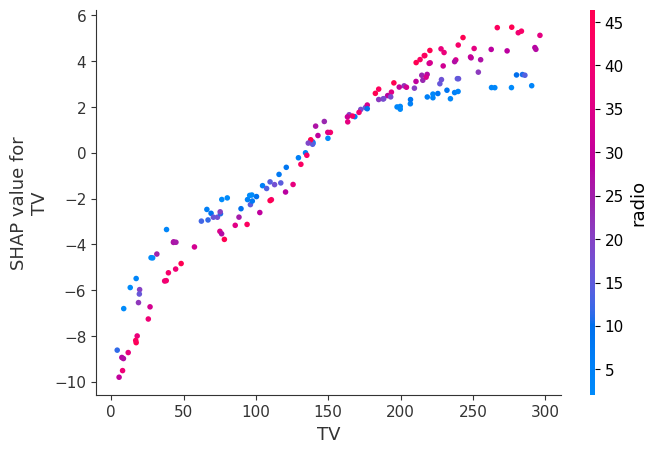

In [30]:
# TV와 Radio 간 Dependence Plot 
shap.dependence_plot("TV", shap_values_train.values, X_train, interaction_index='auto')

- 각 점은 특정 TV 광고 지출에 해당하는 SHAP value를 나타냄
- Y축은 SHAP value이고 X축은 TV 광고 지출
- 색상은 각 인스턴스의 라디오 광고 지출이 기준
- 이 도표를 이해하기 위해 150~300 사이의 TV 광고 지출 구간을 살펴봄

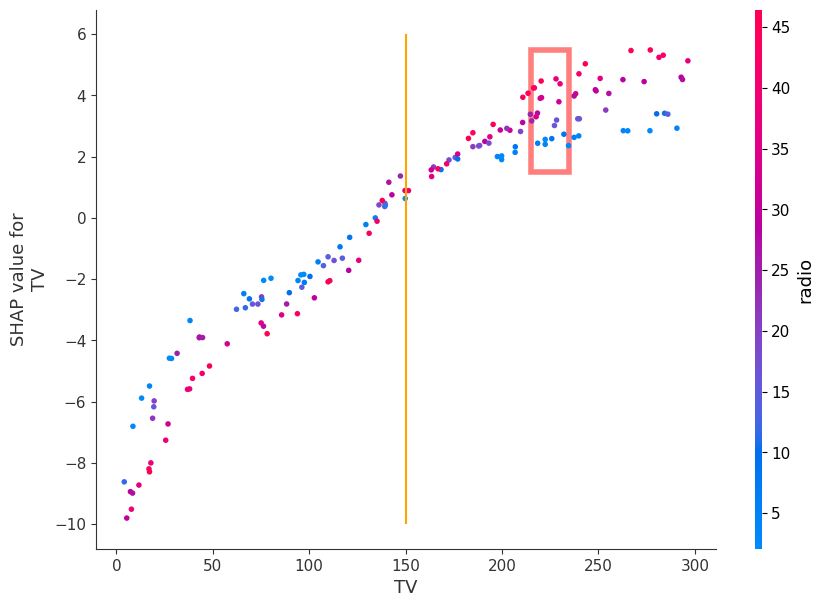

In [31]:
# TV와 Radio 간 Dependence Plot 영역 구분
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.vlines(150, -10, 6, colors='orange')
rect = mpl.patches.Rectangle((215, 1.5), 20, 4, 
                              edgecolor='red', 
                              facecolor='white', 
                              lw=4, 
                              alpha=0.5)
ax.add_patch(rect)

shap.dependence_plot("TV", shap_values_train.values, X_train, interaction_index='auto', ax=ax)


- 이 TV 광고 지출 기간의 SHAP 값 범위는 약 0에서 6 사이
- 이 구간에서 약 220의 TV 광고 지출(붉은 박스 구간)을 예로
    - 이 특정 지출에 대해 SHAP value가 높을수록 라디오 지출도 높아지는 것을 알 수 있음
    - 즉, TV 광고 지출이 150–300인 구간의 라디오 광고 지출과 TV 광고 지출 사이에 긍정적인 상호 작용이 있음을 의미
    - 반면에 TV 광고 지출의 0에서 150 사이의 TV 광고 지출 구간에는 음의 상호작용이 있음



## Force plot



- 지금까지 SHAP value의 글로벌 해석 진행함
- 이번에는 SHAP value의 로컬(개별 인스턴스) 해석 살펴봄
- 로컬 해석은 포스 플롯 활용함
- 데이터는 주 단위 인스턴스임
- 특정 주에서의 마케팅 채널 영향 해석 시 포스 플롯 사용함


In [33]:
# force Plot을 사용한 로컬 해석

# JavaScript 라이브러리 초기화 (필수!)
shap.initjs()

i = 0     # 첫번째 SHAP Value에 대한 인덱스
j = 134   # 트레인 데이터의 해당 인스턴스에 대한 인덱스 값

# Force Plot
shap.force_plot(explainer.expected_value, 
                shap_values_train.values[i], 
                features=X_train.loc[j], 
                feature_names=X_train.columns)

- 파란색 막대와 빨간색 막대는 TV, 라디오, 신문에 대한 SHAP value 나타냄
- 막대 길이는 SHAP value 크기 의미함
- 막대 색상은 SHAP value 방향 나타냄 (양수면 빨간색, 음수면 파란색임)
- 예측 값은 굵은 검정색으로 표시됨
- 선 그래프에 기본값도 있음
- 각 채널별 인스턴스 값 또는 광고 지출 값도 함께 표시됨
- 이전에 계산한 값과 비교 가능함


출처: https://medium.com/@Gomok/shap-%EA%B7%B8%EB%9E%98%EC%84%9C-%EB%AD%90%EA%B0%80-%EC%A4%91%ED%97%8C%EB%94%94-3028abff0870